### Imports

In [5]:
# To embed plots in the notebooks
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np # numpy library
import scipy.io
from scipy.spatial import distance # load distance function
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing as preproc # load preprocessing function

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## 3 Use the receiver operator curve (ROC) and determine specificity and sensitivity:
> (a) Make a function `[sens, spec] = roc_data( y, y_true, cut)` that takes as input the estimated response y, the true response ytrue and the cut off value cut, and outputs the sensitivity and specificity.
*Hint: compute TP, TN, FP and FN. From there, sensitivity and specificity is easily computed.*

In [6]:
def roc_data(y, y_true, cut):
    """Calculate the sensitivity and specificity of a given class 

    Keyword arguments:
    y_hat [ndarray] -- The estimated probability for each observation belonging to the given class
    y_true [ndarray]-- The actual class label for the observations
    cut    float -- The cutoff at which the sensitivity and specificity are to be calculated
    
    Return:
    the sensitivity[float] and specificity[float] at each of the cutoff value.
    """
    # Convert predictions to binary based on cutoff
    y_pred = (y >= cut).astype(int)
    y_true = (y_true > 0).astype(int)  # Convert to 0/1
    
    # Calculate confusion matrix elements
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    # Calculate sensitivity (True Positive Rate) and specificity (True Negative Rate)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    return sensitivity, specificity

>(b) Run the blocks below which use your `roc_data`. The output plot illustrates the data for the next exercise. Try to adjust the cut off value for the classification rule, which is also plotted in the figure.

In [7]:
def init_data():
    n1 = 20
    n2 = 100
    n = n1 + n2
    mu1 = np.array([2, 3])
    mu2 = np.array([3, 5])
    SIGMA1 = np.array([[1, 1.5], [1.5, 3]])
    SIGMA2 = np.array([[2, 1], [1, 1]])

    r1 = np.random.multivariate_normal(mu1,SIGMA1,n1)
    r2 = np.random.multivariate_normal(mu2,SIGMA2,n2)
    X = np.concatenate((r1, r2), axis=0)
    y = np.concatenate((np.ones((n1)), -np.ones((n2))), axis=0)

    return X, y, r1, r2, n1, n2, n

def abline(ax, slope, intercept,linetype):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, linetype)

def plotData(ax, lda, data,cut):
    _, _, r1, r2, _, _, _ = data

    ax.plot(r1[:,0],r1[:,1],'r+',label='Positive class')
    ax.plot(r2[:,0],r2[:,1],'bx',label='Negative class')
    abline(ax,-lda.coef_[0][0]/lda.coef_[0][1], -lda.intercept_[0]/lda.coef_[0][1],'-g')
    abline(ax,-lda.coef_[0][0]/lda.coef_[0][1], -(lda.intercept_[0]-cut)/lda.coef_[0][1],'-k')
    ax.set_title('Observations')
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='lower right')

def plotROC(ax,lda,data,cut):
    X, y, _, _, _, _, _ = data
    
    y_score = lda.decision_function(X)
    fpr, tpr, _ = roc_curve(y, y_score)
    
    y_pred = lda.decision_function(X)
    sens, spec = roc_data(y_pred, y, cut)
    
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',lw=lw)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.plot(1-spec, sens,'*k')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')

def calcConfusionMatrix(lda,data,cut):
    X, y, _, _, _, _, _ = data
    
    f = X@lda.coef_[0] + lda.intercept_[0] - cut
    tp = np.sum((f > 0) & (y == 1));
    tn = np.sum((f < 0) & (y == -1));
    fp = np.sum((f > 0) & (y == -1));
    fn = np.sum((f < 0) & (y == 1));
    
    return ConfusionMatrixDisplay(np.array([[tn, fp],[fn, tp]])), tp/(tp+fn),  tn/(tn+fp), tp/(tp+fp), tp/(tp+fp)

data = init_data()
X, y, _, _, _, _, _ = data
lda = LinearDiscriminantAnalysis().fit(X, y)

The sensitivity is 0.55
The specificity is 0.99
The precision is 0.9166666666666666
The Negative Predictive Value is 0.9166666666666666


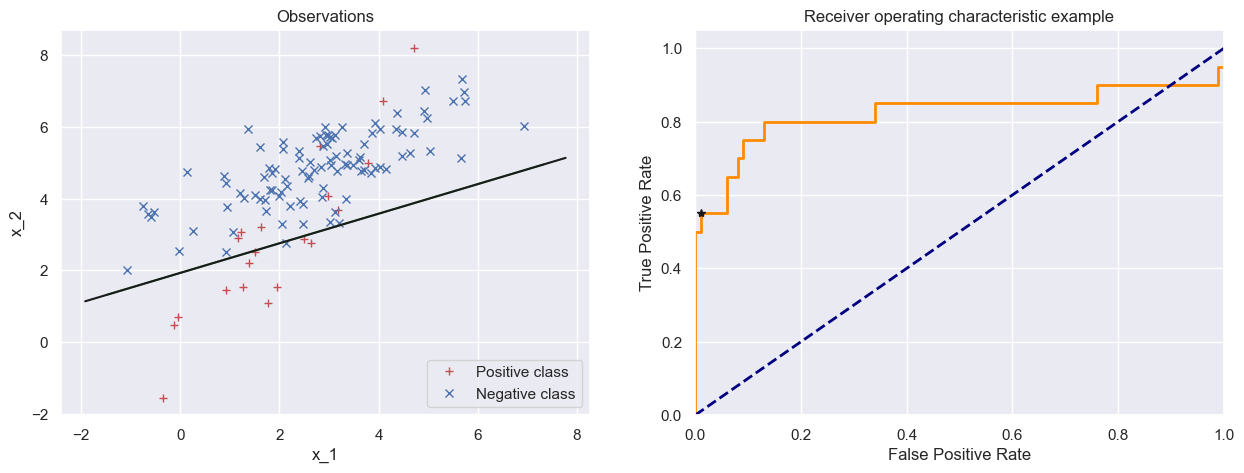

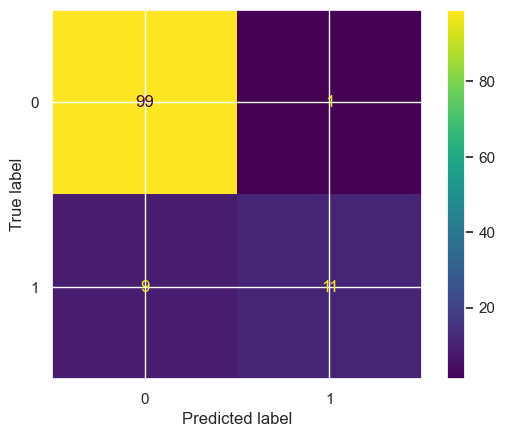

In [8]:
value = 0

fig, ax = plt.subplots(1,2,figsize=(15,5))

plotData(ax[0], lda, data, value)
plotROC(ax[1],lda,data, value)
disp, sens, spec, PPV, NPV = calcConfusionMatrix(lda, data, value)
disp.plot()
print("The sensitivity is {}".format(sens))
print("The specificity is {}".format(spec))
print("The precision is {}".format(PPV))
print("The Negative Predictive Value is {}".format(NPV))

>(c) Assume you are developing a mammography system for General Electrics, and that the GUI is showing the two features you have extracted to find suspicious image regions. GE has ordered the system to have a sensitivity of 95% to make sure very few lesions go undetected. Discuss this solution with your mates. What are you sacrificing to get such a sensitive system? Which sensitivity would you recommend based on the given data?